<a href="https://colab.research.google.com/github/brunoedcf/NLP_2022_1/blob/main/3_Gram_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pythainlp
!pip install advertools
!pip install -U gensim

# ***Imports***

In [ ]:
import pandas as pd
import numpy as np
import re
import keras
import pythainlp
import advertools as adv
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Embedding, GlobalMaxPooling1D, Activation, Dropout

import nltk
nltk.download('punkt')

In [3]:
data_path = 'https://raw.githubusercontent.com/brunoedcf/bert-base-multilingual-cased_Language_Classifier/main/dataset.csv'

In [4]:
df = pd.read_csv(data_path)

In [5]:
df

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


In [6]:
df['language'].value_counts()

Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: language, dtype: int64

In [29]:
text = df['Text'].tolist()
lang = df['language'].tolist()

# ***Pre-Processing***

In [8]:
def pre_process(text):
  treated = re.sub(r'[\/\。\・\、\，\「\」\、\-\（\）\『\』\；\：\：\－\”\·\–\~\—\«\—]', ' ', text)
  treated = re.sub(r'[\[\]\,\.\"\'\(\)\%\:\;\<\>\?\!\+\*\&\$\#\@\《\》\—]', ' ', treated)
  treated = re.sub(r'\\n', ' ', treated)
  treated = re.sub(r'[0-9]', ' ', treated)
  treated = re.sub(r'\\u200c', ' ', treated)
  treated = re.sub(r'\\u200b', ' ', treated)
  treated = re.sub(r'\s+', ' ', treated)
  treated = treated.lower()

  return treated

In [30]:
text = [pre_process(t) for t in text]

In [31]:
for i, row in enumerate(text):

  if lang[i] == 'Thai':
    for stopword in pythainlp.corpus.common.thai_stopwords():
      if stopword in row:
        text[i] = pre_process(re.sub(stopword, ' ', row).strip())

  elif lang[i] == 'Japanese':
    for stopword in adv.stopwords['japanese']:
      if stopword in row:
        text[i] = pre_process(re.sub(stopword, ' ', row).strip())

  elif lang[i] == "Chinese":
    for stopword in adv.stopwords['chinese']:
      if stopword in row:
        text[i] = pre_process(re.sub(stopword, ' ', row).strip())

# ***Create 3-Grams***

In [11]:
def create_3gram(text):

  if len(text) < 6:
    text += '###'

  tokens = []
  tokens.append('##' + text[0])
  tokens.append('#' + text[0] + text[1])
  for i in range(0, len(text) - 2):
    tokens.append(text[i:i+3])
  
  tokens.append( text[len(text)-2 : len(text)] + '#')
  tokens.append(text[len(text)-1] + '##')

  tokens = [re.sub(r'\s','#', t) for t in tokens]

  return tokens

In [32]:
text_3gram = [create_3gram(t) for t in text]

In [33]:
text[0][:5], text[0][len(text[0])-5: len(text[0])]

('kleme', 'tvald')

In [40]:
text_3gram[0][:5], text_3gram[0][len(text_3gram[0])-5: len(text_3gram[0])]

(['##k', '#kl', 'kle', 'lem', 'eme'], ['tva', 'val', 'ald', 'ld#', 'd##'])

# ***Split in Training, Test and Validation***

In [14]:
train_x, test_x, train_y, test_y = train_test_split(text_3gram, lang, test_size=0.33, random_state=42)
test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y, test_size=0.33, random_state=42)

# ***Labels to Categorical***

In [15]:
df_train_y = pd.Categorical(train_y)
df_train_y_int = df_train_y.codes
train_y = to_categorical(df_train_y_int)

df_test_y = pd.Categorical(test_y)
df_test_y_int = df_test_y.codes
test_y = to_categorical(df_test_y_int)

df_valid_y = pd.Categorical(valid_y)
df_valid_y_int = df_valid_y.codes
valid_y = to_categorical(df_valid_y_int)

# ***Count Vocabulary***

In [16]:
vocab = {}
for text in train_x:
  for word in text:
    if word not in vocab:
      vocab[word] = 1

In [17]:
vocab_size = len(vocab)
vocab_size

352124

# ***Tokenizer***

In [18]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_x)

In [19]:
word_index = tokenizer.word_index

In [20]:
vocab_size = len(word_index) + 1

In [21]:
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)
valid_sequences = tokenizer.texts_to_sequences(valid_x)

In [22]:
max_length = 64
trunc_type = 'post'
padding_type = 'post'
n = 100

In [23]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# ***Model***

In [35]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = n, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=6, strides=1))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(22, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 100)           35212500  
                                                                 
 conv1d_1 (Conv1D)           (None, 59, 128)           76928     
                                                                 
 activation_3 (Activation)   (None, 59, 128)           0         
                                                                 
 dropout_3 (Dropout)         (None, 59, 128)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                      

In [36]:
sgd = SGD(learning_rate=0.02)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded, train_y,validation_data=(valid_padded, valid_y), epochs=50)

Epoch 1/50
461/461 [==============================] - 3s 5ms/step - loss: 3.0921 - accuracy: 0.0476 - val_loss: 3.0897 - val_accuracy: 0.0522
Epoch 2/50
461/461 [==============================] - 2s 4ms/step - loss: 3.0886 - accuracy: 0.0541 - val_loss: 3.0877 - val_accuracy: 0.0797
Epoch 3/50
461/461 [==============================] - 2s 5ms/step - loss: 3.0826 - accuracy: 0.0647 - val_loss: 3.0825 - val_accuracy: 0.0747
Epoch 4/50
461/461 [==============================] - 2s 5ms/step - loss: 3.0734 - accuracy: 0.0767 - val_loss: 3.0718 - val_accuracy: 0.1386
Epoch 5/50
461/461 [==============================] - 2s 5ms/step - loss: 3.0447 - accuracy: 0.1162 - val_loss: 3.0284 - val_accuracy: 0.2321
Epoch 6/50
461/461 [==============================] - 2s 4ms/step - loss: 2.9066 - accuracy: 0.1516 - val_loss: 2.7968 - val_accuracy: 0.1941
Epoch 7/50
461/461 [==============================] - 2s 4ms/step - loss: 2.6629 - accuracy: 0.1801 - val_loss: 2.5795 - val_accuracy: 0.3093
Epoch 

In [37]:
target_names = pd.Categorical(lang).categories

y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(df_test_y_int,y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Arabic       0.98      0.95      0.97       240
     Chinese       0.86      0.90      0.88       221
       Dutch       0.96      0.93      0.94       209
     English       0.86      0.91      0.88       212
    Estonian       0.82      0.95      0.88       222
      French       0.93      0.93      0.93       217
       Hindi       0.99      0.95      0.97       239
  Indonesian       0.95      0.95      0.95       212
    Japanese       0.96      0.92      0.94       212
      Korean       0.99      0.96      0.97       219
       Latin       0.89      0.89      0.89       218
     Persian       0.98      0.97      0.97       212
   Portugese       0.91      0.96      0.93       211
      Pushto       0.98      0.96      0.97       216
    Romanian       0.97      0.95      0.96       232
     Russian       0.98      0.96      0.97       237
     Spanish       0.93      0.92      0.93       216
     Swedish       0.99    

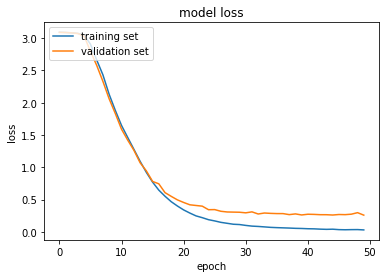

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('historyfine_3_gram_CNN.eps', format='eps')

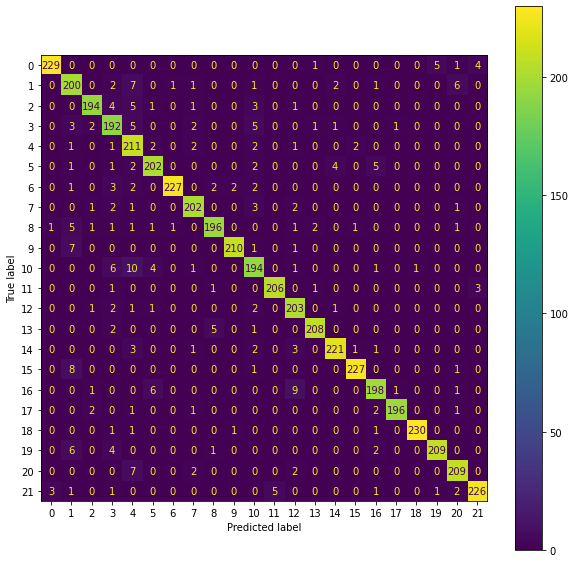

<Figure size 432x288 with 0 Axes>

In [39]:
disp = ConfusionMatrixDisplay.from_predictions(df_test_y_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.show()
plt.savefig('confmatrix_3_gram_CNN.eps', format='eps')